## $\text{Ola} - \text{Ensemble Learning Business Case}$

- $\text{Topic: Ensemble Learning in Driver Attrition Prediction}$
- $\text{Duration: $3$ week}$

### $\text{Context }-$

- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it's very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

### $\text{Problem Statement }-$
You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like,
- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### $\text{Data Preparation }-$

In [ ]:
!pip install catboost optuna

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
sns.set_style("darkgrid")

In [ ]:
!gdown https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv

Downloading...
From: https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 24.3MB/s]


In [ ]:
ola = pd.read_csv('ola_driver_scaler.csv', index_col=0)
ola.sample(5)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
4500,04/01/19,667,31.0,0.0,C8,2,78143,09/09/18,NaN,2,2,200000,1
18489,02/01/20,2706,36.0,0.0,C16,0,76463,10/07/19,NaN,3,3,0,2
7874,09/01/19,1175,42.0,1.0,C27,2,52588,12/06/17,NaN,1,1,300000,2
15822,10/01/20,2347,37.0,0.0,C15,1,54695,24/04/20,NaN,3,3,547330,2
18067,08/01/20,2639,29.0,1.0,C12,0,92763,13/02/20,NaN,3,3,0,1


$\text{Data Card}$

- **DD-MM-YY** : Reporting Date (Monthly)
- **Driver_ID** : Unique id for drivers
- **Age** : Age of the driver
- **Gender** : Gender of the driver $-$ Male : $0$, Female: $1$
- **City** : City Code of the driver
- **Education_Level** : Education level $-$ $0$ for $10$+ ,$1$ for $12$+ ,$2$ for graduate
- **Income** : Monthly average Income of the driver
- **Date Of Joining** : Joining date for the driver
- **LastWorkingDate** : Last date of working for the driver
- **Joining Designation** : Designation of the driver at the time of joining
- **Grade** : Grade of the driver at the time of reporting
- **Total Business Value** : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- **Quarterly Rating** : Quarterly rating of the driver: $1$, $2$, $3$, $4$, $5$ (higher is better)

### $\text{Basic Statistics}$

#### $\text{In this section, we'll try to identify }-$


1.   Number of rows and columns of data.
2.   Data type of each column, non-null values in each column and memory usage by the dataset.
3.   How data looks like, by taking sample of 5 rows out of it.
4.   Distinct values in each column.
5.   If dataset contains duplicated rows.

In [ ]:
# Number of rows and columns of data.
print(f'Number of row: {ola.shape[0]: >8}')
print(f'Number of column: {ola.shape[1]}')

Number of row:    19104
Number of column: 13


- Although there are $19k$ rows but the data is monthly reporting of drivers.
- Apart from that `Total Business Value` is changing monthly and `Quarterly Rating` is changing quarterly.

In [ ]:
# Data type of each column, non-null values in each column and memory usage by the dataset.
ola.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.0+ MB


In [ ]:
# Null values
ola.isnull().sum().rename('Missing Values').reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12
index,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
Missing Values,0,0,61,52,0,0,0,0,17488,0,0,0,0


In [ ]:
# Distinct values in each column
ola.nunique().rename('Distinct Values').reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12
index,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
Distinct Values,24,2381,36,2,29,3,2383,869,493,5,5,10181,4


In [ ]:
# If dataset contains duplicated rows.
ola.duplicated().sum()

np.int64(0)

### $\text{Exploratory Data Analysis}$

In [ ]:
ola['Age'] = ola.groupby('Driver_ID')['Age'].ffill().bfill().astype(int)
ola['Gender'] = ola.groupby('Driver_ID')['Gender'].ffill().bfill().astype(int)
ola['LastWorkingDate'] = ola.groupby('Driver_ID')['LastWorkingDate'].bfill()

In [ ]:
datetime_columns = ['MMM-YY', 'Dateofjoining', 'LastWorkingDate']
for column in datetime_columns:
  ola[column] = pd.to_datetime(ola[column], format='mixed')

In [ ]:
ola['Churned'] = ola['LastWorkingDate'].notna()

- `LastWorkingDate` is our target column; a non-null value indicates that the driver has already $left$ the company.
- We kept it for the analysis, but otherwise we made categorical column out of it $-$ `Churned` $-$ with boolean values.

`LastWorkingDate` is only provided for the final month of employment for each driver. For drivers who have left, hence we populated the `LastWorkingDate` across all their relevant rows.

In [ ]:
ola.isnull().sum().rename('Missing Values').reset_index().T.style.hide(axis='columns')

index,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churned
Missing Values,0,0,0,0,0,0,0,0,8745,0,0,0,0,0


In [ ]:
X, y = ola.copy(), ola['Churned']

In [ ]:
last_date_train = pd.concat([X['MMM-YY'], X['Dateofjoining'], X['LastWorkingDate']]).max()
X['Number of Days Working'] = (X['LastWorkingDate'].fillna(last_date_train) - X['Dateofjoining']).dt.days

In [ ]:
X['Reporting Month'] = X['MMM-YY'].dt.month
X['Reporting Year'] = X['MMM-YY'].dt.year

In [ ]:
X['Joining Month'] = X['Dateofjoining'].dt.month
X['Joining Year'] = X['Dateofjoining'].dt.year

##### $\text{Data Split }- \text{train, test}$

In [ ]:
unique_driver_ids = X['Driver_ID'].unique()
train_ids, test_ids = train_test_split(unique_driver_ids, test_size=0.25, random_state=42)

X_train = X[X['Driver_ID'].isin(train_ids)].copy()
y_train = y[X['Driver_ID'].isin(train_ids)].copy()

X_test = X[X['Driver_ID'].isin(test_ids)].copy()
y_test = y[X['Driver_ID'].isin(test_ids)].copy()

##### $Churn\ Analysis\ -$

In [ ]:
print(f"Number of Drivers still working: {X_train[~y_train].groupby('Driver_ID').size().count()}")

Number of Drivers still working: 572


In [ ]:
print(f"Number of Drivers left: {X_train[y_train].groupby('Driver_ID').size().count()}")

Number of Drivers left: 1213


<Axes: >

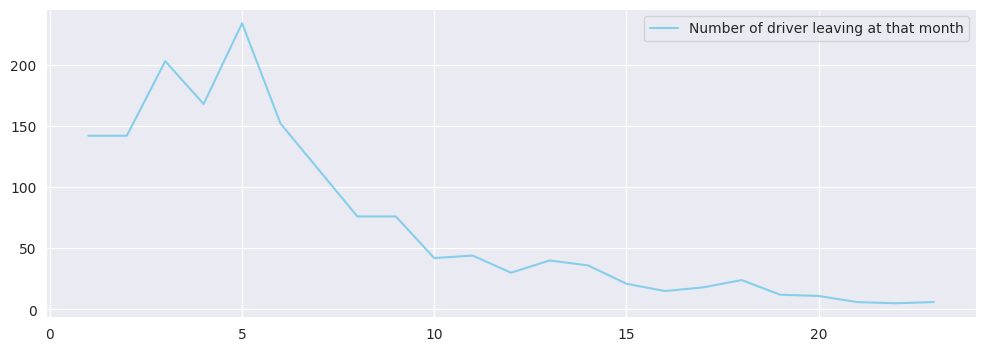

In [ ]:
data = X_train.groupby('Driver_ID').size().sort_values().reset_index()
res = dict()
for i in range(1, 24):
  res[i] = X_train[X_train['Driver_ID'].isin(data[data[0] == i]['Driver_ID'].values)].groupby('Driver_ID').size().count()
plt.figure(figsize=(12, 4))
sns.lineplot(x=list(res.keys()), y=list(res.values()), color='skyblue', label='Number of driver leaving at that month')

As we can see churn is highest at $5^{th}$ month, with this information along with the nature of the data (time series, frequency monthly) we're specifically going to capture the $lag$ of first $4$ month of a driver to understand the cause leading upto churn at $5^{th}$ month.

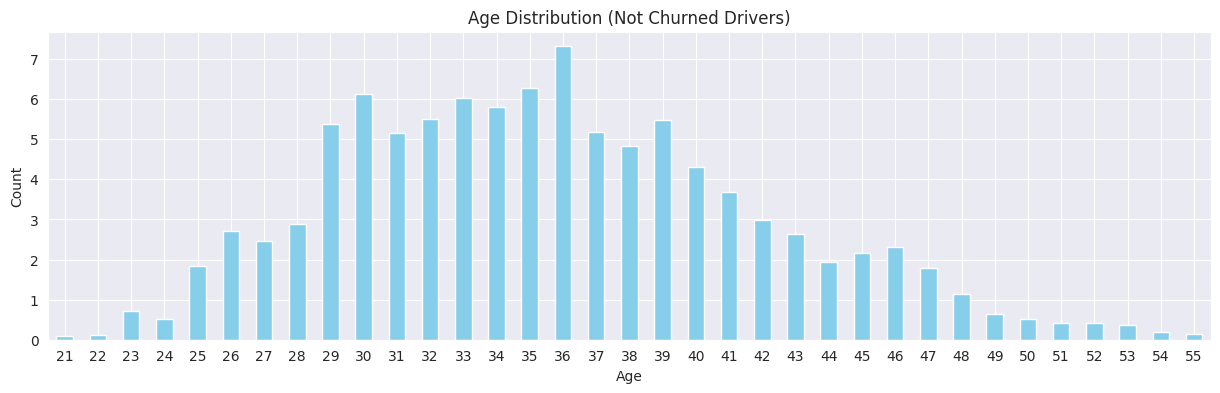

In [ ]:
# Examining Age column (distribution)
plt.figure(figsize=(15, 4))
X_train[~y_train]['Age'].value_counts(normalize=True).mul(100).sort_index().plot(kind='bar', color='skyblue')
plt.title('Age Distribution (Not Churned Drivers)')
plt.xlabel('Age')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

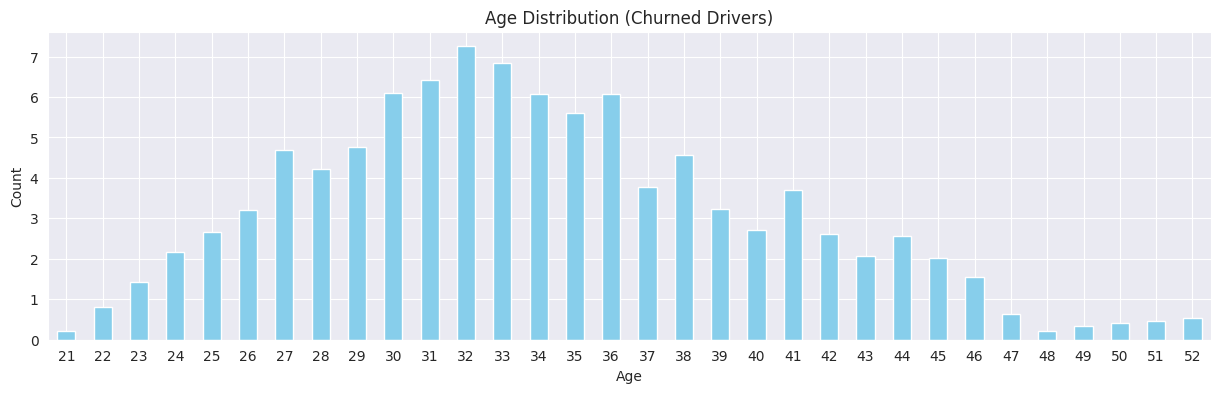

In [ ]:
# Age distribution
plt.figure(figsize=(15, 4))
X_train[y_train]['Age'].value_counts(normalize=True).mul(100).sort_index().plot(kind='bar', color='skyblue')
plt.title('Age Distribution (Churned Drivers)')
plt.xlabel('Age')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

In [ ]:
# Examining Gender column
X_train['Gender Label'] = X_train['Gender'].map({0: 'Male', 1: 'Female'})

In [ ]:
(
  X_train.groupby(['Driver_ID', 'Gender']).first()['Gender Label']
  .value_counts(normalize=True).mul(100).round(2).reset_index().T
)

,0,1
Gender Label,Male,Female
proportion,59.05,40.95


Data is approximately balanced w.r.t. Gender with $58\%$ males and $42\%$ females.

Text(0.5, 1.0, 'Churned Drivers')

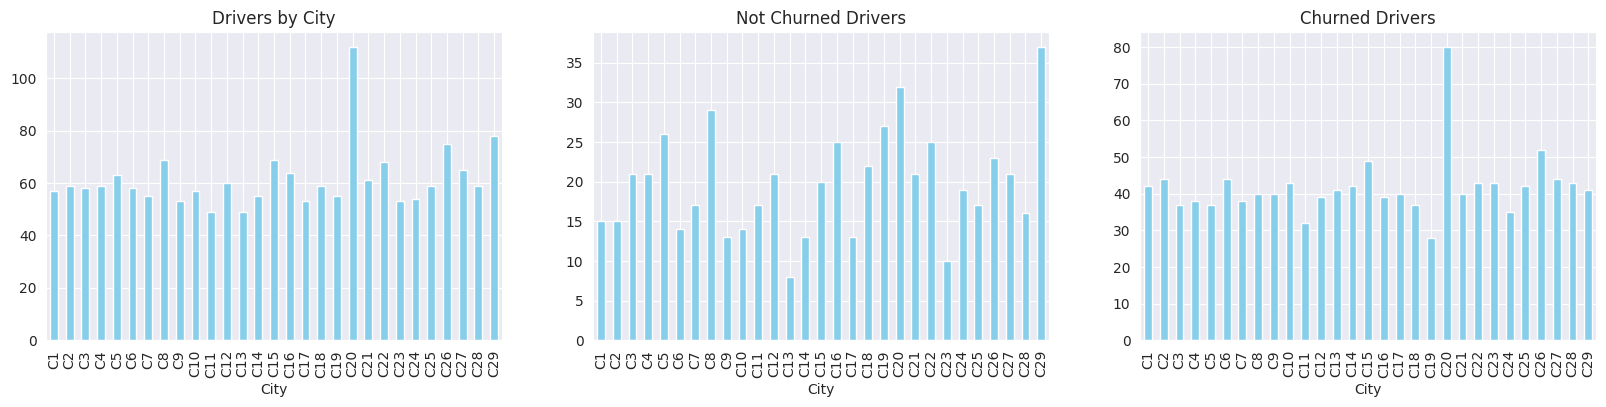

In [ ]:
# Examining City column
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

(
  X_train.groupby('Driver_ID')['City'].value_counts().groupby(level='City').count()
  .sort_index(key=lambda x: x.str[1:].astype(int)).plot(kind='bar', color='skyblue', ax=ax[0])
)
ax[0].set_title('Drivers by City')

(
  X_train[~y_train].groupby('Driver_ID')['City'].value_counts().groupby(level='City').count()
  .sort_index(key=lambda x: x.str[1:].astype(int)).plot(kind='bar', color='skyblue', ax=ax[1])
)
ax[1].set_title('Not Churned Drivers')

(
  X_train[y_train].groupby('Driver_ID')['City'].value_counts().groupby(level='City').count()
  .sort_index(key=lambda x: x.str[1:].astype(int)).plot(kind='bar', color='skyblue', ax=ax[2])
)
ax[2].set_title('Churned Drivers')

There is **no** noticeable pattern in the churned drivers by city.

The spike for city `C20` is because it has the most drivers, so drivers are leaving in proportion.

Text(0.5, 1.0, 'Distribution of monthly Income')

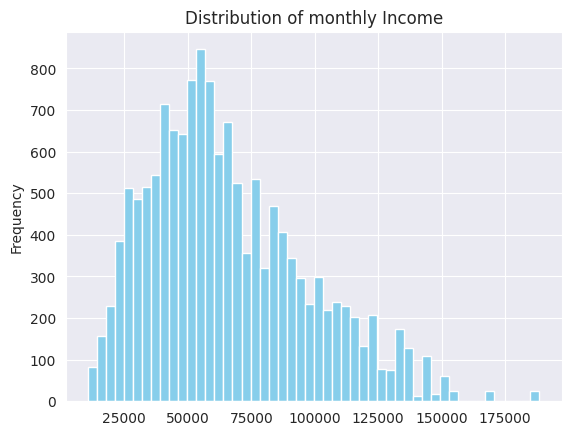

In [ ]:
# Examining Income column
X_train['Income'].plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribution of monthly Income')

As we can clearly see that the monthly income data is $right$ skewed.

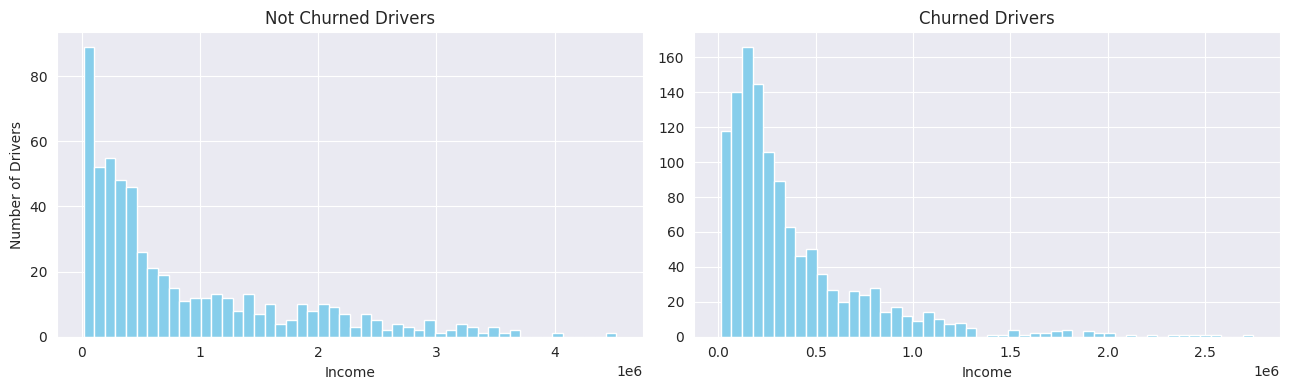

In [ ]:
plot_data = {
  'Not Churned': X_train[~y_train].groupby('Driver_ID')['Income'].sum(),
  'Churned': X_train[y_train].groupby('Driver_ID')['Income'].sum()
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

plot_data['Not Churned'].plot(kind='hist', bins=50, color='skyblue', ax=axes[0])
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Number of Drivers')
axes[0].set_title('Not Churned Drivers')

plot_data['Churned'].plot(kind='hist', bins=50, color='skyblue', ax=axes[1])
axes[1].set_xlabel('Income')
axes[1].set_ylabel('')
axes[1].set_title('Churned Drivers')

plt.tight_layout()
plt.show()

If we look closely at the income range, more number of drivers are leaving because of the low income.

In [ ]:
X_train.groupby('Driver_ID')['Income'].sum().describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
Income,1785.0,528094.839216,627943.84466,12456.0,142490.0,295638.0,652872.0,4522032.0


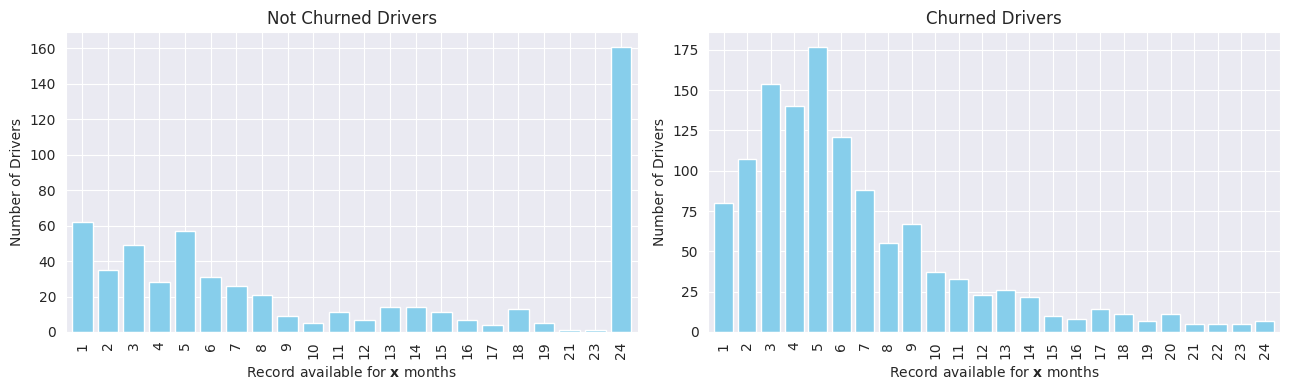

In [ ]:
# Examining Dateofjoining column
plot_data = {
  'Not Churned': X_train[~y_train].groupby('Driver_ID').count()['Dateofjoining'].value_counts().sort_index(),
  'Churned': X_train[y_train].groupby('Driver_ID').count()['Dateofjoining'].value_counts().sort_index()
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

plot_data['Not Churned'].plot(kind='bar', color='skyblue', ax=axes[0], width=0.8)
axes[0].set_xlabel('Record available for $\mathbf{x}$ months')
axes[0].set_ylabel('Number of Drivers')
axes[0].set_title('Not Churned Drivers')

plot_data['Churned'].plot(kind='bar', color='skyblue', ax=axes[1], width=0.8)
axes[1].set_xlabel('Record available for $\mathbf{x}$ months')
axes[1].set_ylabel('Number of Drivers')
axes[1].set_title('Churned Drivers')

plt.tight_layout()
plt.show()

In [ ]:
X_train[~y_train].groupby('Driver_ID').count()['Dateofjoining'].describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
Dateofjoining,572.0,11.377622,8.978319,1.0,3.0,7.0,24.0,24.0


In [ ]:
X_train[y_train].groupby('Driver_ID').count()['Dateofjoining'].describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
Dateofjoining,1213.0,6.435284,4.61274,1.0,3.0,5.0,8.0,24.0


More than half ($55\%$) of the drivers are leaving after working for less than $5$ months.

$\text{Net change in drivers per month } -$

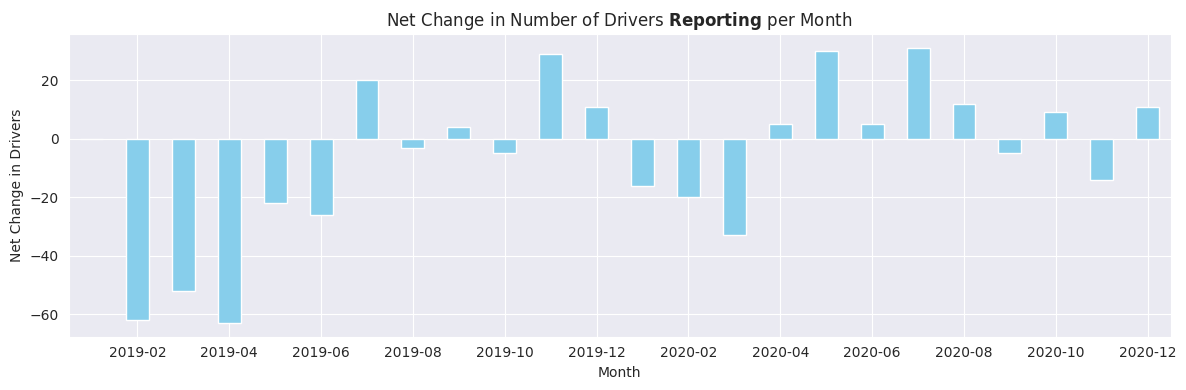

In [ ]:
drivers_per_month = X_train.groupby('MMM-YY')['Driver_ID'].nunique()
net_change = drivers_per_month.diff().fillna(0)

plt.figure(figsize=(12, 4))
net_change.plot(kind='bar', color='skyblue')
plt.title('Net Change in Number of Drivers $\mathbf{Reporting}$ per Month')
plt.xlabel('Month')
plt.ylabel('Net Change in Drivers')

locs, labels = plt.xticks()
new_locs = locs[1::2]
new_labels = [label.get_text()[:-12] for label in labels][1::2]
plt.xticks(new_locs, new_labels, rotation=0)

plt.tight_layout()
plt.show()

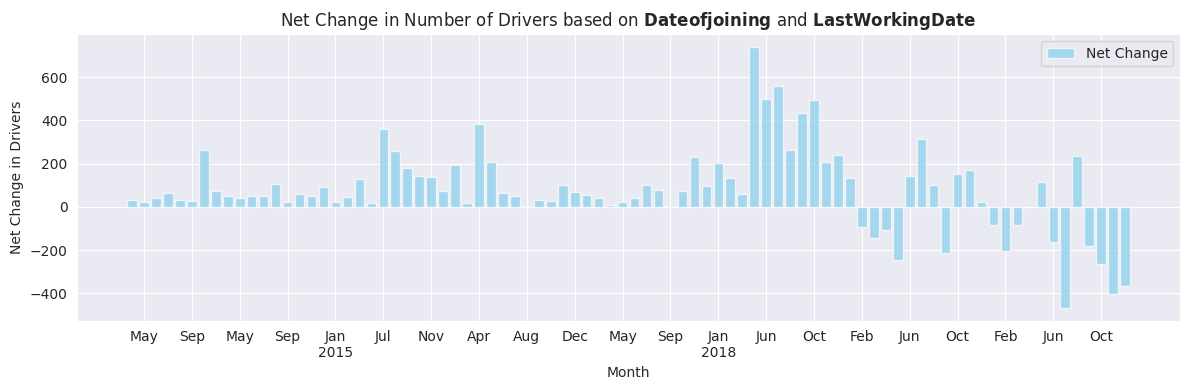

In [ ]:
monthly_activity = pd.DataFrame({
  'Joining': X_train.groupby(X_train['Dateofjoining'].dt.to_period('M')).size(),
  'Leaving': X_train.groupby(X_train['LastWorkingDate'].dt.to_period('M')).size()
}).fillna(0)

monthly_activity['Net Change'] = monthly_activity['Joining'] - monthly_activity['Leaving']

plt.figure(figsize=(12, 4))
plt.bar(monthly_activity.index.astype(str), monthly_activity['Net Change'], color='skyblue', alpha=0.7, label='Net Change')
plt.title('Net Change in Number of Drivers based on $\mathbf{Dateofjoining}$ and $\mathbf{LastWorkingDate}$')
plt.xlabel('Month')
plt.ylabel('Net Change in Drivers')

dates = monthly_activity.index
labels = []
last_year = None
for date in dates:
  if date.year != last_year:
    labels.append(date.strftime('%b %Y'))
    last_year = date.year
  else:
    labels.append(date.strftime('%b'))

locs, current_labels = plt.xticks()
alternate_locs = locs[1::4]
alternate_labels = ["\n".join(labels[i].split()) for i in range(1, len(labels), 4)]

plt.xticks(ticks=alternate_locs, labels=alternate_labels, rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Since the beginning of $2019$, our data reveals a net loss of drivers (more leaving than joining), **which is primarily due to the fact that we commenced recording churn in that year**.

<Axes: xlabel='Joining Designation'>

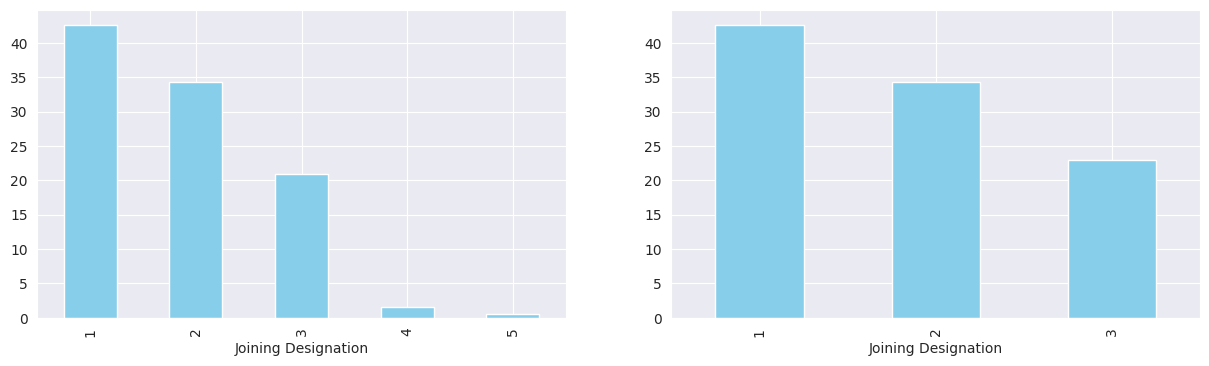

In [ ]:
# Examining Joining Designation column
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
(
  X_train.groupby('Driver_ID').agg({'Joining Designation':'first'})['Joining Designation']
  .value_counts(normalize=True).mul(100).plot(kind='bar', color='skyblue', ax=ax[0])
)

X_train['Joining Designation'] = X_train['Joining Designation'].apply(lambda x: x if x < 3 else 3)
(
  X_train.groupby('Driver_ID').agg({'Joining Designation':'first'})['Joining Designation']
  .value_counts(normalize=True).mul(100).plot(kind='bar', color='skyblue', ax=ax[1])
)

- Majority of the drivers ($> 80\%$) have Joining Designation as $1$ or $2$, this suggest that majority of the drivers have no or little previous experience, hence provided with minimum ($1$) designation.

- Following that we merged imbalanced classes ($4$ and $5$) with class $3$.

<Axes: xlabel='Grade'>

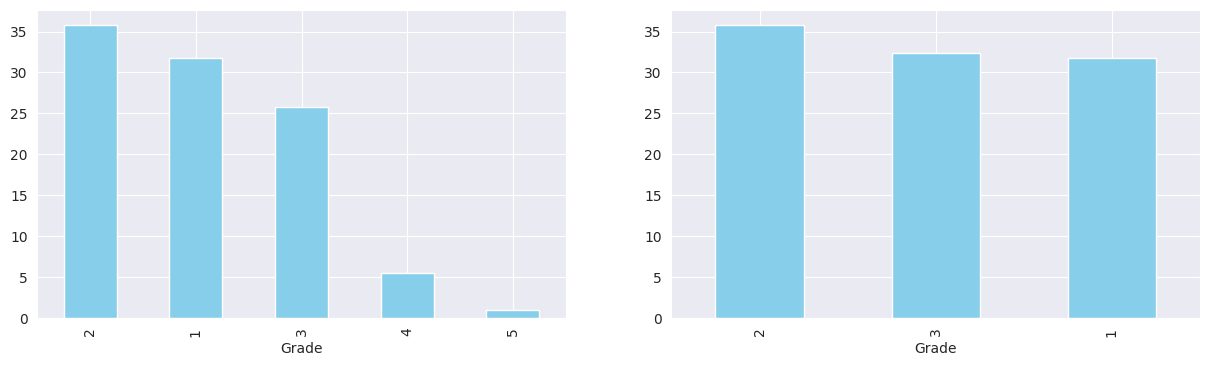

In [ ]:
# Examining Grade column
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
(
  X_train.groupby('Driver_ID').agg({'Grade':'first'})['Grade']
  .value_counts(normalize=True).mul(100).plot(kind='bar', color='skyblue', ax=ax[0])
)

X_train['Grade'] = X_train['Grade'].apply(lambda x: x if x < 3 else 3)
(
  X_train.groupby('Driver_ID').agg({'Grade':'first'})['Grade']
  .value_counts(normalize=True).mul(100).plot(kind='bar', color='skyblue', ax=ax[1])
)

Grade $4$ and $5$ are the imbalanced classes, I merged these classes with class $3$ to make all the classes more balanced.

In [ ]:
# Examining Total Business Value column
X_train.groupby('Driver_ID')['Total Business Value'].sum().describe().reset_index().T

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
Total Business Value,1785.0,4641011.383754,9231486.586479,-1385530.0,0.0,850280.0,4266380.0,95331060.0


In [ ]:
tbv = X_train.groupby('Driver_ID')['Total Business Value'].sum().reset_index()
print(f"""
  Drivers with negative or no total business value: {round(100 * tbv[tbv["Total Business Value"] <= 0].shape[0] / tbv.shape[0], 2)}%
""", end='\n\n')


  Drivers with negative or no total business value: 30.31%




As we have seen in the analysis of `Income` colum, every driver is getting monthly income but $\sim 30\%$ of them (we can say that even after group by because there is no driver with $0$ income) are not making contribution to `Total Business Value`.

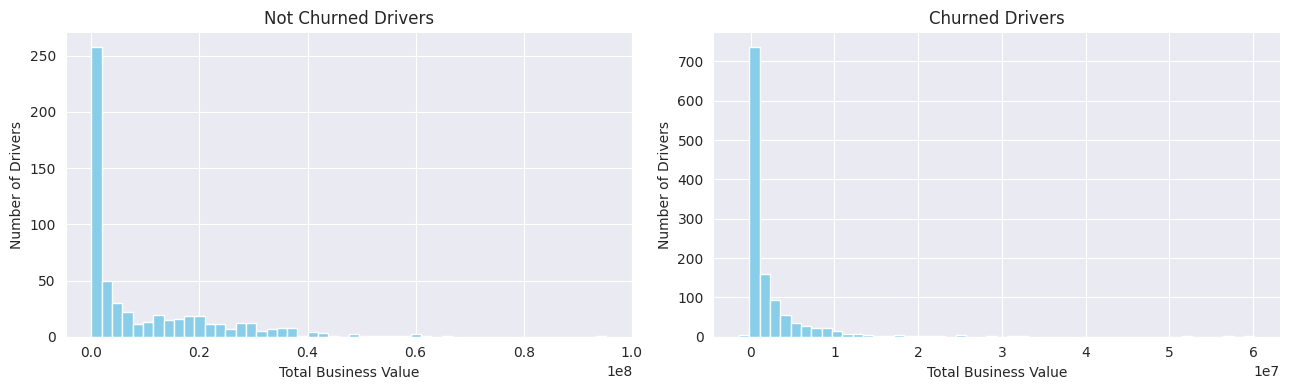

In [ ]:
plot_data = {
  'Not Churned': X_train[~y_train].groupby('Driver_ID')['Total Business Value'].sum(),
  'Churned': X_train[y_train].groupby('Driver_ID')['Total Business Value'].sum()
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

plot_data['Not Churned'].plot(kind='hist', bins=50, color='skyblue', ax=axes[0])
axes[0].set_xlabel('Total Business Value')
axes[0].set_ylabel('Number of Drivers')
axes[0].set_title('Not Churned Drivers')

plot_data['Churned'].plot(kind='hist', bins=50, color='skyblue', ax=axes[1])
axes[1].set_xlabel('Total Business Value')
axes[1].set_ylabel('Number of Drivers')
axes[1].set_title('Churned Drivers')

plt.tight_layout()
plt.show()

- Drivers who are leaving the company are contributing less to the `Total Business Value`.
- The comparision with the `Income` also reflects the same thing (below graph).

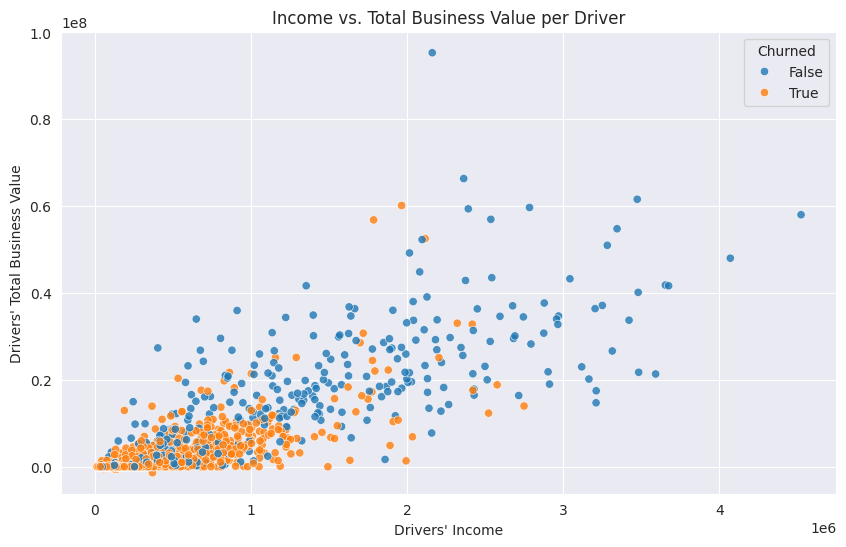

In [ ]:
plot_data = X_train.groupby(['Driver_ID']).agg({
  'Income': 'sum',
  'Total Business Value': 'sum',
  'Churned': 'first'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Total Business Value', hue='Churned', data=plot_data, alpha=0.8)
plt.title('Income vs. Total Business Value per Driver')
plt.xlabel("Drivers' Income")
plt.ylabel("Drivers' Total Business Value")
plt.show()

$\text{Why the Non positive Total Business Value?}$

This pattern holds for $only$ negative total business value but with non-positive total business values we have more data points to confirm.

In [ ]:
(
  X_train[X_train['Total Business Value'] <= 0].groupby('Driver_ID').agg({'Total Business Value': 'sum', 'Churned': 'first'})
  ['Churned'].value_counts(normalize=True).mul(100).round(2).rename('Non positive TBV').reset_index().T
)

,0,1
Churned,True,False
Non positive TBV,70.36,29.64


In [ ]:
(
  X_train[X_train['Total Business Value'] <= 0].groupby('Driver_ID')
  .agg({'Total Business Value': 'sum', 'Quarterly Rating': 'first', 'Churned': 'first'})
  [['Churned','Quarterly Rating']].value_counts(normalize=True).mul(100).rename('Non positive TBV')
  .reset_index().sort_values(by=['Quarterly Rating', 'Churned']).T.style.hide(axis='columns')
)

Churned,False,True,False,True,False,True,False,True
Quarterly Rating,1,1,2,2,3,3,4,4
Non positive TBV,21.845238,58.690476,5.000000,8.809524,1.964286,2.023810,0.833333,0.833333


In [ ]:
(
  X_train[X_train['Total Business Value'] <= 0][['Churned', 'Joining Designation']].value_counts(normalize=True).mul(100)
  .rename('Non positive TBV').reset_index().sort_values(by=['Joining Designation', 'Churned']).T.style.hide(axis='columns')
)

Churned,False,True,False,True,False,True
Joining Designation,1,1,2,2,3,3
Non positive TBV,7.441488,30.246049,9.361872,25.765153,9.981996,17.203441


Evidently, over $70\%$ of churned drivers have a `Quarterly Rating` of $1$ (minimum) and a `Joining Designation` less than $3$.

> This clearly indicates that driving skills and passenger experience are important factors for a driver to contribute to the total business value.

In [ ]:
df_joined_before_2019_left_in_2019 = ola[
  (ola['Dateofjoining'].dt.year < 2019) &
  (ola['LastWorkingDate'].dt.year == 2019)
]

joined_before_2019 = ola[ola['Dateofjoining'].dt.year < 2019].groupby('Driver_ID').size().count()
df_joined_before_2019_left_in_2019 = df_joined_before_2019_left_in_2019.groupby('Driver_ID').size().count()
percentage_left_2019 = round(100 * df_joined_before_2019_left_in_2019 / joined_before_2019, 2)

#
df_joined_in_2019_left_in_2020 = ola[
  (ola['Dateofjoining'].dt.year == 2019) &
  (ola['LastWorkingDate'].dt.year == 2020)
]

df_joined_in_2019 = ola[ola['Dateofjoining'].dt.year == 2019].groupby('Driver_ID').size().count()
df_joined_in_2019_left_in_2020 = df_joined_in_2019_left_in_2020.groupby('Driver_ID').size().count()
percentage_left_2020 = round(100 * df_joined_in_2019_left_in_2020 / df_joined_in_2019, 2)

#
df_joined_in_2020_left_in_2020_dec = ola[
  (ola['Dateofjoining'].dt.year == 2020) &
  (ola['LastWorkingDate'].dt.year == 2020) &
  (ola['LastWorkingDate'].dt.month == 12)
]

df_joined_in_2020 = ola[ola['Dateofjoining'].dt.year == 2020].groupby('Driver_ID').size().count()
df_joined_in_2020_left_in_2020_dec = df_joined_in_2020_left_in_2020_dec.groupby('Driver_ID').size().count()
percentage_left_2020_dec = round(100 * df_joined_in_2020_left_in_2020_dec / df_joined_in_2020, 2)

In [ ]:
print(f"Drivers who left in 2019: {percentage_left_2019 : > 15}")
print(f"Drivers who left in 2020: {percentage_left_2020 : > 15}")
print(f"Drivers who left in 2020 December: {percentage_left_2020_dec : > 5}")

Drivers who left in 2019:           62.86
Drivers who left in 2020:           46.53
Drivers who left in 2020 December:  5.75


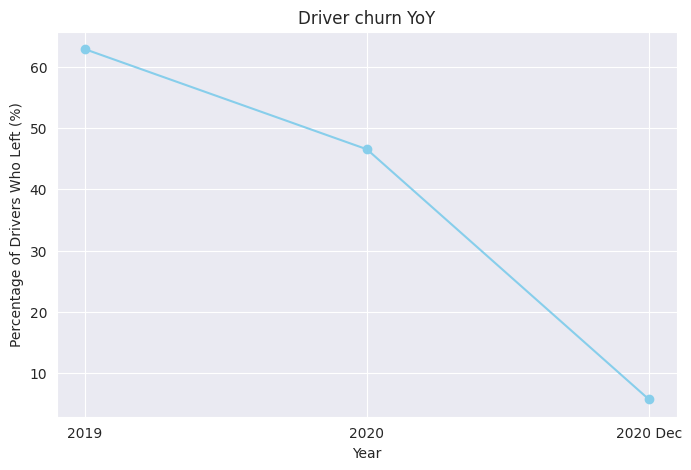

In [ ]:
years = ['2019', '2020', '2020 Dec']
percentages = [percentage_left_2019, percentage_left_2020, percentage_left_2020_dec]

plt.figure(figsize=(8, 5))
plt.plot(years, percentages, marker='o', linestyle='-', color='skyblue')
plt.title('Driver churn YoY')
plt.xlabel('Year')
plt.ylabel('Percentage of Drivers Who Left (%)')
plt.grid(True)
plt.show()

The data shows that driver churn is decreasing YoY, a positive downtrend.

In [ ]:
# Extracting quarter from MMM-YY
X_train['Quarter'] = X_train['MMM-YY'].dt.quarter
X_test['Quarter'] = X_test['MMM-YY'].dt.quarter

#### Heatmap $-$

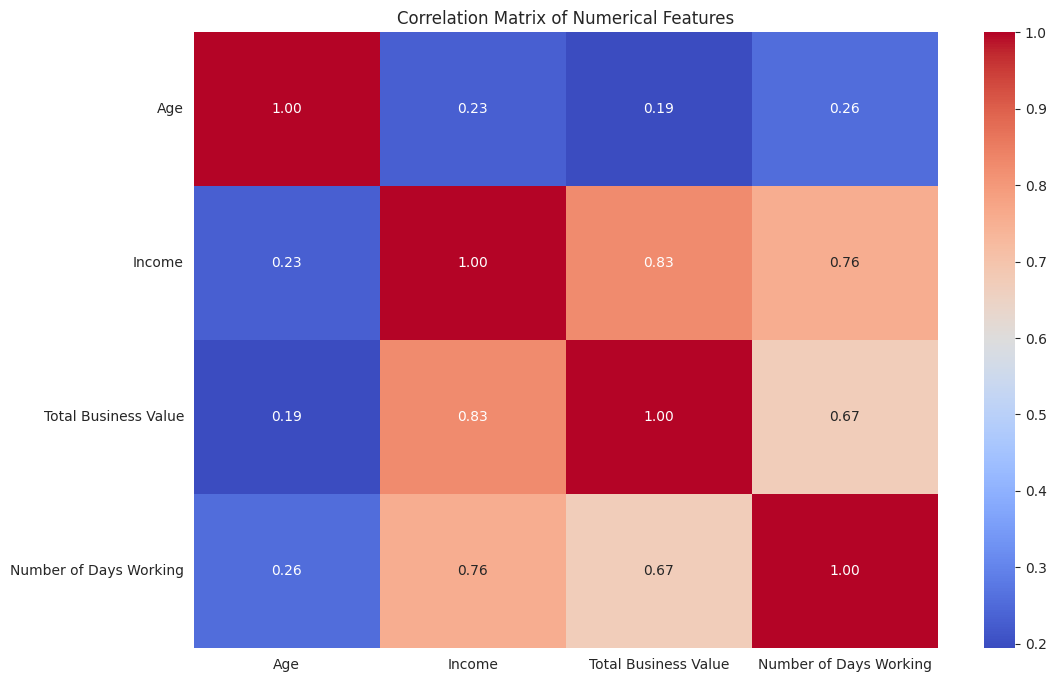

In [ ]:
numerical_features = ['Age', 'Income', 'Total Business Value', 'Number of Days Working']
correlation_matrix = X_train.groupby(['Driver_ID']).agg({
  'Age': 'first',
  'Income': 'sum',
  'Total Business Value': 'sum',
  'Number of Days Working': 'first',
})[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
describe = X_train.groupby('Driver_ID').agg({
  'Age': 'first',
  'Income': 'sum',
  'Total Business Value': 'sum',
  'Number of Days Working': 'first',
})[numerical_features].describe().T
describe["range"] = describe["max"] - describe["min"]
describe["mode"] = X.mode().iloc[0]
describe["IQR"] = describe["75%"] - describe["25%"]
describe["unique"] = X.nunique()
describe["skew"] = X.select_dtypes(include=np.number).skew()
describe["kurt"] = X.select_dtypes(include=np.number).kurtosis()
describe[
    ["unique", "range", "mean", "mode", "std", "min", "25%", "50%", "75%", "max", "IQR", "skew", "kurt"]
].style.format("{:.1f}")

,unique,range,mean,mode,std,min,25%,50%,75%,max,IQR,skew,kurt
Age,36.0,32.0,33.2,36.0,5.8,21.0,29.0,33.0,37.0,53.0,8.0,0.4,-0.1
Income,2383.0,4509576.0,528094.8,48747.0,627943.8,12456.0,142490.0,295638.0,652872.0,4522032.0,510382.0,0.7,0.1
Total Business Value,10181.0,96716590.0,4641011.4,0.0,9231486.6,-1385530.0,0.0,850280.0,4266380.0,95331060.0,4266380.0,7.0,95.2
Number of Days Working,885.0,2828.0,434.8,150.0,567.5,0.0,100.0,194.0,476.0,2828.0,376.0,0.9,-0.3


### $\text{Hypothesis Testing }-$

In [ ]:
hypothesis = pd.DataFrame()

In [ ]:
hypothesis['Current_Quarterly_Rating'] = X_train.groupby(['Driver_ID', 'Quarter'])['Quarterly Rating'].first()
hypothesis['Current_Quarterly_Sum_TBV'] = X_train.groupby(['Driver_ID', 'Quarter'])['Total Business Value'].sum()
hypothesis['Current_Quarterly_Mean_TBV'] = X_train.groupby(['Driver_ID', 'Quarter'])['Total Business Value'].mean()
hypothesis['Active_Months'] = X_train.groupby(['Driver_ID', 'Quarter']).size()

hypothesis.reset_index(inplace=True)

---

- **Null Hypothesis** ($H_0$)**:** There is no significant difference in the mean of quarterly sum of TBV across the different categories of the quarterly rating.
- **Alternative Hypothesis** ($H_1$)**:** There is a significant difference in the mean of quarterly sum of TBV across at least some of the categories of the quarterly rating.

In [ ]:
model = ols('Current_Quarterly_Sum_TBV ~ C(Current_Quarterly_Rating)', data=hypothesis).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                   sum_sq      df           F  PR(>F)
C(Current_Quarterly_Rating)  1.932200e+16     3.0  859.985555     0.0
Residual                     3.347704e+16  4470.0         NaN     NaN


In [ ]:
# Post-hoc analysis
if anova_table['PR(>F)'].iloc[0] < 0.05:
  print("Result: There is a statistically significant difference in Mean of Sum TBV across rating categories.", end='\n\n')
  tukey_result = pairwise_tukeyhsd(
    endog=hypothesis['Current_Quarterly_Sum_TBV'],
    groups=hypothesis['Current_Quarterly_Rating'],
    alpha=0.05
  )
  print(tukey_result)
  print("Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.")
else:
  print("Result: No statistically significant difference in Mean of Sum TBV across rating categories.")

Result: There is a statistically significant difference in Mean of Sum TBV across rating categories.

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     1      2 1862004.9832   0.0 1602743.1604  2121266.806   True
     1      3 3763574.3203   0.0 3454728.6411 4072419.9994   True
     1      4 6978972.6515   0.0 6574601.9902 7383343.3127   True
     2      3 1901569.3371   0.0 1552999.8239 2250138.8502   True
     2      4 5116967.6682   0.0 4681501.6149 5552433.7216   True
     3      4 3215398.3312   0.0 2748708.2366 3682088.4258   True
-----------------------------------------------------------------
Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.


---

- **Null Hypothesis** ($H_0$)**:** There is no significant difference in the mean of monthly average (within quarter) of TBV across the different categories of the quarterly rating.
- **Alternative Hypothesis** ($H_1$)**:** There is a significant difference in the mean of monthly average (within quarter) of TBV across at least some of the categories of the quarterly rating.

In [ ]:
model = ols('Current_Quarterly_Mean_TBV ~ C(Current_Quarterly_Rating)', data=hypothesis).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                   sum_sq      df           F  PR(>F)
C(Current_Quarterly_Rating)  9.530332e+14     3.0  1121.50667     0.0
Residual                     1.266171e+15  4470.0         NaN     NaN


In [ ]:
# Post-hoc analysis
if anova_table['PR(>F)'].iloc[0] < 0.05:
  print("Result: There is a statistically significant difference in Mean of Mean TBV across rating categories.", end='\n\n')
  tukey_result = pairwise_tukeyhsd(
    endog=hypothesis['Current_Quarterly_Mean_TBV'],
    groups=hypothesis['Current_Quarterly_Rating'],
    alpha=0.05
  )
  print(tukey_result)
  print("Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.")
else:
  print("Result: No statistically significant difference in Mean of Mean TBV across rating categories.")

Result: There is a statistically significant difference in Mean of Mean TBV across rating categories.

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     1      2  439199.7486   0.0  388778.7733  489620.7238   True
     1      3  804225.7221   0.0  744161.7289  864289.7153   True
     1      4 1568257.3886   0.0 1489615.7942  1646898.983   True
     2      3  365025.9736   0.0  297236.5296  432815.4175   True
     2      4   1129057.64   0.0 1044368.6454 1213746.6347   True
     3      4  764031.6665   0.0  673270.2521  854793.0808   True
-----------------------------------------------------------------
Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.


- This result strongly confirms that your `Current_Quarterly_Rating` is a $highly\ effective\ discriminator$ not just for the total business value (*Sum TBV*), but also for the average monthly business value (*Mean TBV*) generated by drivers every quarter.

- As the `Current_Quarterly_Rating` increases, the mean (**meandiff**) *Sum TBV* and *Mean TBV* of drivers in that category consistently and significantly increases.

- The $F-statistic$ for *Mean TBV* is higher than for *Sum TBV*. This implies that `Current_Quarterly_Rating` explains more of the variance in *Mean TBV* than in *Sum_TBV*.

> This suggests that the rating system is more sensitive to a driver's average monthly performance than to their absolute total output for quarter.

---
- **Null Hypothesis** ($H_0$)**:** There is no significant difference in the mean active working days across the different quarterly rating categories.

- **Alternative Hypothesis** ($H_1$)**:** There is a significant difference in the mean active working days across at least some of the quarterly rating categories.

In [ ]:
model = ols('Active_Months ~ C(Current_Quarterly_Rating)', data=hypothesis).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                  sum_sq      df          F  PR(>F)
C(Current_Quarterly_Rating)  3619.116285     3.0  710.93651     0.0
Residual                     7585.041963  4470.0        NaN     NaN


In [ ]:
# Post-hoc analysis
if anova_table['PR(>F)'].iloc[0] < 0.05:
  print("Result: There is a statistically significant difference in mean Active Working months across rating categories.", end='\n\n')
  tukey_result = pairwise_tukeyhsd(
    endog=hypothesis['Active_Months'],
    groups=hypothesis['Current_Quarterly_Rating'],
    alpha=0.05
  )
  print(tukey_result)
  print("Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.")
else:
  print("Result: No statistically significant difference in mean Active Working months across rating categories.")

Result: There is a statistically significant difference in mean Active Working months across rating categories.

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   1.3637    0.0  1.2402 1.4871   True
     1      3   2.0715    0.0  1.9245 2.2185   True
     1      4   2.1949    0.0  2.0024 2.3874   True
     2      3   0.7079    0.0  0.5419 0.8738   True
     2      4   0.8312    0.0  0.6239 1.0385   True
     3      4   0.1234 0.4823 -0.0988 0.3455  False
---------------------------------------------------
Interpretation: Look at 'reject' column. 'True' means a significant difference between the pair.


- Active working months are a strong indicator of performance for lower-to-mid-tier drivers (between quarterly ratings $1, 2, 3$).
- Active working months are **NOT** a differentiator for top-tier drivers ($3$ and $4$)

### $\text{Feature Engineering}$

Adding $5$ features,
1. Total business value of last $4$ months (lagged data, as discussed in the churn analysis section).
2. Quarterly rating of the last quarter.


In [ ]:
X_train['TBV_minus_one'] = X_train.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(1)
X_train['TBV_minus_two'] = X_train.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(2)
X_train['TBV_minus_three'] = X_train.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(3)
X_train['TBV_minus_four'] = X_train.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(4)

X_test['TBV_minus_one'] = X_test.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(1)
X_test['TBV_minus_two'] = X_test.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(2)
X_test['TBV_minus_three'] = X_test.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(3)
X_test['TBV_minus_four'] = X_test.sort_values(by=['Driver_ID', 'MMM-YY']).groupby('Driver_ID')['Total Business Value'].shift(4)

In [ ]:
X_train['TBV_minus_one'] = X_train['TBV_minus_one'].fillna(X_train['Total Business Value'].min() - 1)
X_train['TBV_minus_two'] = X_train['TBV_minus_two'].fillna(X_train['Total Business Value'].min() - 1)
X_train['TBV_minus_three'] = X_train['TBV_minus_three'].fillna(X_train['Total Business Value'].min() - 1)
X_train['TBV_minus_four'] = X_train['TBV_minus_four'].fillna(X_train['Total Business Value'].min() - 1)

X_test['TBV_minus_one'] = X_test['TBV_minus_one'].fillna(X_test['Total Business Value'].min() - 1)
X_test['TBV_minus_two'] = X_test['TBV_minus_two'].fillna(X_test['Total Business Value'].min() - 1)
X_test['TBV_minus_three'] = X_test['TBV_minus_three'].fillna(X_test['Total Business Value'].min() - 1)
X_test['TBV_minus_four'] = X_test['TBV_minus_four'].fillna(X_test['Total Business Value'].min() - 1)

In [ ]:
previous_quarter_rating = (
  X_train.sort_values(by=['Driver_ID', 'MMM-YY']).groupby(['Driver_ID', 'Reporting Year', 'Quarter'])['Quarterly Rating']
  .first().reset_index()
)
previous_quarter_rating['quarter_sort_key'] = previous_quarter_rating['Reporting Year'] * 10 + previous_quarter_rating['Quarter']
previous_quarter_rating.sort_values(by=['Driver_ID', 'quarter_sort_key'], inplace=True)
previous_quarter_rating['Previous_Quarterly_Rating'] = previous_quarter_rating.groupby('Driver_ID')['Quarterly Rating'].shift(1)

previous_quarter_rating_test = (
  X_test.sort_values(by=['Driver_ID', 'MMM-YY']).groupby(['Driver_ID', 'Reporting Year', 'Quarter'])['Quarterly Rating']
  .first().reset_index()
)
previous_quarter_rating_test['quarter_sort_key'] = previous_quarter_rating_test['Reporting Year'] * 10 + previous_quarter_rating_test['Quarter']
previous_quarter_rating_test.sort_values(by=['Driver_ID', 'quarter_sort_key'], inplace=True)
previous_quarter_rating_test['Previous_Quarterly_Rating'] = previous_quarter_rating_test.groupby('Driver_ID')['Quarterly Rating'].shift(1)

In [ ]:
X_train['quarter_sort_key'] = X_train['Reporting Year'] * 10 + X_train['Quarter']
X_train = pd.merge(
  X_train,
  previous_quarter_rating[['Driver_ID', 'quarter_sort_key', 'Previous_Quarterly_Rating']],
  on=['Driver_ID', 'quarter_sort_key'],
  how='left'
)

X_test['quarter_sort_key'] = X_test['Reporting Year'] * 10 + X_test['Quarter']
X_test = pd.merge(
  X_test,
  previous_quarter_rating[['Driver_ID', 'quarter_sort_key', 'Previous_Quarterly_Rating']],
  on=['Driver_ID', 'quarter_sort_key'],
  how='left'
)

In [ ]:
X_train['Previous_Quarterly_Rating'] = X_train['Previous_Quarterly_Rating'].fillna(-1)
X_test['Previous_Quarterly_Rating'] = X_test['Previous_Quarterly_Rating'].fillna(-1)

In [ ]:
X_train.drop(columns=[
  'MMM-YY', 'Driver_ID', 'Quarter', 'Gender Label', 'Dateofjoining',
  'LastWorkingDate', 'Churned', 'quarter_sort_key'
], inplace=True)

### $\text{Ensembeling}$

##### $\text{Preprocessing test data }-$

In [ ]:
X_test['Joining Designation'] = X_test['Joining Designation'].apply(lambda x: x if x < 3 else 3)
X_test['Grade'] = X_test['Grade'].apply(lambda x: x if x < 3 else 3)

X_test.drop(columns=['MMM-YY', 'Driver_ID', 'Quarter', 'Dateofjoining', 'LastWorkingDate', 'Churned', 'quarter_sort_key'], inplace=True)

In [ ]:
# Applying one-hot encoding for City column
X_train_encoded = pd.get_dummies(X_train, columns=['City'])
X_train_encoded = pd.get_dummies(X_train, columns=['City'], drop_first=True)

X_test_encoded = pd.get_dummies(X_test, columns=['City'], drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns)

### Boosting (CatBoost) $-$

In [ ]:
def objective_catboost(X_train, y_train, trial):
  params = {
    'iterations': trial.suggest_int('iterations', 50, 500),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    'depth': trial.suggest_int('depth', 4, 10),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'verbose': 0,
    'random_seed': 42,
    'auto_class_weights':'Balanced'
  }

  categorical_features_indices = [i for i, col in enumerate(X_train.columns) if col == 'City']
  model = CatBoostClassifier(**params, cat_features=categorical_features_indices)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_catboost(X_train, y_train, trial), n_trials=50, show_progress_bar=True)

[I 2025-06-02 12:46:06,988] A new study created in memory with name: no-name-0d321134-911c-40f3-880d-87672e563399


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-02 12:46:32,183] Trial 0 finished with value: 0.9079383445340781 and parameters: {'iterations': 256, 'learning_rate': 0.03312907736672939, 'depth': 6, 'l2_leaf_reg': 1.5782946471319637, 'border_count': 99}. Best is trial 0 with value: 0.9079383445340781.
[I 2025-06-02 12:48:20,267] Trial 1 finished with value: 0.869631089513122 and parameters: {'iterations': 437, 'learning_rate': 0.4857965494658372, 'depth': 10, 'l2_leaf_reg': 0.07792169250868428, 'border_count': 233}. Best is trial 0 with value: 0.9079383445340781.
[I 2025-06-02 12:48:26,508] Trial 2 finished with value: 0.905011657302218 and parameters: {'iterations': 191, 'learning_rate': 0.06639273662113958, 'depth': 5, 'l2_leaf_reg': 0.05534921592980489, 'border_count': 88}. Best is trial 0 with value: 0.9079383445340781.
[I 2025-06-02 12:48:30,654] Trial 3 finished with value: 0.9168331543231172 and parameters: {'iterations': 166, 'learning_rate': 0.8291758171600231, 'depth': 5, 'l2_leaf_reg': 0.08592551407148993, 'bor

In [ ]:
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
  print("    {}: {}".format(key, value))

Best trial:
  Value:  0.9275276354461746
  Params: 
    iterations: 153
    learning_rate: 0.24470428117636836
    depth: 9
    l2_leaf_reg: 0.04686701219119427
    border_count: 238


In [ ]:
best_catboost_params = study.best_trial.params

best_catboost_params['random_seed'] = 42
best_catboost_params['verbose'] = 0

categorical_features_indices = [i for i, col in enumerate(X_train.columns) if col == 'City']
best_catboost_model = CatBoostClassifier(**best_catboost_params, cat_features=categorical_features_indices)
best_catboost_model.fit(X_train, y_train)

y_pred = best_catboost_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"F1 score of the test set: {accuracy:.4f}")

F1 score of the test set: 0.9150


In [ ]:
feature_importance = best_catboost_model.get_feature_importance()
feature_names = X_train.columns

feature_importance_series = pd.Series(feature_importance, index=feature_names)
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

print("Feature Importance:")
print(sorted_feature_importance)

Feature Importance:
Number of Days Working       28.343360
Joining Year                 18.605223
Joining Month                15.484740
Income                        8.639500
City                          5.525274
Age                           5.320275
Reporting Year                4.033002
Education_Level               3.245180
Gender                        2.614607
Grade                         2.243953
Quarterly Rating              1.914200
Reporting Month               1.407346
Joining Designation           1.111932
Previous_Quarterly_Rating     0.770768
Total Business Value          0.221793
TBV_minus_four                0.172038
TBV_minus_two                 0.129119
TBV_minus_one                 0.111845
TBV_minus_three               0.105845
dtype: float64


### Bagging (RandomForest) $-$

In [ ]:
def objective_rf(X_train_encoded, y_train, trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 500)
  max_depth = trial.suggest_int('max_depth', 2, 32)
  min_samples_split = trial.suggest_float('min_samples_split', 0.01, 1.0)
  min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 1)

  model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    class_weight='balanced'
  )

  score = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='f1').mean()
  return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_rf(X_train_encoded, y_train, trial), n_trials=50, show_progress_bar=True)

[I 2025-06-02 13:04:52,029] A new study created in memory with name: no-name-bfac4339-4fcf-46d4-b0ee-75e3d6665b8c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-02 13:04:54,955] Trial 0 finished with value: 0.4235081314219461 and parameters: {'n_estimators': 175, 'max_depth': 9, 'min_samples_split': 0.7452758597812598, 'min_samples_leaf': 0.5362925321255471}. Best is trial 0 with value: 0.4235081314219461.
[I 2025-06-02 13:04:56,671] Trial 1 finished with value: 0.5646473719282752 and parameters: {'n_estimators': 157, 'max_depth': 27, 'min_samples_split': 0.7005095095342252, 'min_samples_leaf': 0.0772669604766422}. Best is trial 1 with value: 0.5646473719282752.
[I 2025-06-02 13:05:00,570] Trial 2 finished with value: 0.28233698061932344 and parameters: {'n_estimators': 374, 'max_depth': 11, 'min_samples_split': 0.21655460775259666, 'min_samples_leaf': 0.3639485862665491}. Best is trial 1 with value: 0.5646473719282752.
[I 2025-06-02 13:05:08,700] Trial 3 finished with value: 0.749114898498897 and parameters: {'n_estimators': 369, 'max_depth': 15, 'min_samples_split': 0.2619113396904781, 'min_samples_leaf': 0.12009882239367946}. Bes

In [ ]:
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
  print("    {}: {}".format(key, value))

Best trial:
  Value:  0.8059203943340622
  Params: 
    n_estimators: 484
    max_depth: 22
    min_samples_split: 0.02184560798204808
    min_samples_leaf: 0.01081712692454935


In [ ]:
# Train the final model with the best parameters
best_rf_params = study.best_trial.params
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf_model.fit(X_train_encoded, y_train)

# Evaluate the best model on the test set
accuracy = best_rf_model.score(X_test_encoded, y_test)
print(f"F1 score of the test set: {accuracy:.4f}")

F1 score of the test set: 0.7975


In [ ]:
feature_importance_rf = best_rf_model.feature_importances_
feature_names_rf = X_train_encoded.columns

feature_importance_series_rf = pd.Series(feature_importance_rf, index=feature_names_rf)
sorted_feature_importance_rf = feature_importance_series_rf.sort_values(ascending=False)

print("Feature Importance (Random Forest):")
print(sorted_feature_importance_rf.iloc[:10])

Feature Importance (Random Forest):
Number of Days Working       0.193038
Quarterly Rating             0.145656
Reporting Year               0.132210
Total Business Value         0.094399
Joining Year                 0.079104
Previous_Quarterly_Rating    0.063897
Reporting Month              0.059321
TBV_minus_one                0.038576
TBV_minus_four               0.038195
TBV_minus_three              0.035268
dtype: float64


### Stacking (Mixture of Models) $-$

In [ ]:
estimators = [('lr', LogisticRegression()), ('cb', CatBoostClassifier()), ('rf', RandomForestClassifier())]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [ ]:
def objective_stacking(X_train_encoded, y_train, trial):
  lr_params = {
    'C': trial.suggest_float('lr_C', 0.1, 10.0),
    'solver': trial.suggest_categorical('lr_solver', ['liblinear', 'lbfgs']),
    'max_iter': trial.suggest_int('lr_max_iter', 1000, 5000)
  }

  cb_params = {
    'iterations': trial.suggest_int('iterations', 50, 500),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
    'depth': trial.suggest_int('depth', 4, 10),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
    'border_count': trial.suggest_int('border_count', 32, 255),
    'verbose': 0,
    'random_seed': 42,
    'auto_class_weights':'Balanced'
  }

  rf_params = {
    'n_estimators': trial.suggest_int('rf_n_estimators', 50, 500),
    'max_depth': trial.suggest_int('rf_max_depth', 2, 32),
    'min_samples_split': trial.suggest_float('rf_min_samples_split', 0.01, 1.0),
    'min_samples_leaf': trial.suggest_float('rf_min_samples_leaf', 0.01, 0.5)
  }

  estimators = [
    ('lr', LogisticRegression(**lr_params)),
    ('cb', CatBoostClassifier(**cb_params)),
    ('rf', RandomForestClassifier(**rf_params))
  ]

  final_estimator_params = {
    'C': trial.suggest_float('final_lr_C', 0.1, 10.0),
    'solver': trial.suggest_categorical('final_lr_solver', ['liblinear', 'lbfgs']),
    'max_iter': trial.suggest_int('final_lr_max_iter', 1000, 5000)
  }

  passthrough = trial.suggest_categorical('passthrough', [True, False])

  stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(**final_estimator_params),
    passthrough=passthrough,
    cv=5
  )

  score = cross_val_score(stacking_model, X_train_scaled, y_train, cv=5, scoring='f1').mean()
  return score

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_stacking(X_train_scaled, y_train, trial), n_trials=50, show_progress_bar=True)

[I 2025-06-02 09:38:09,600] A new study created in memory with name: no-name-1325e077-f545-438d-88c3-7172f23e052e


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-02 09:42:37,744] Trial 0 finished with value: 0.9536461454470413 and parameters: {'lr_C': 1.4103103690348513, 'lr_solver': 'liblinear', 'lr_max_iter': 1568, 'iterations': 370, 'learning_rate': 0.10440317848420048, 'depth': 9, 'l2_leaf_reg': 6.7335022444394435, 'border_count': 239, 'rf_n_estimators': 347, 'rf_max_depth': 17, 'rf_min_samples_split': 0.12904923169267435, 'rf_min_samples_leaf': 0.4515341894275837, 'final_lr_C': 4.303168386909216, 'final_lr_solver': 'liblinear', 'final_lr_max_iter': 3805, 'passthrough': True}. Best is trial 0 with value: 0.9536461454470413.
[I 2025-06-02 09:44:07,321] Trial 1 finished with value: 0.9539252769675521 and parameters: {'lr_C': 2.2138680638177557, 'lr_solver': 'liblinear', 'lr_max_iter': 4118, 'iterations': 450, 'learning_rate': 0.1823118947689095, 'depth': 5, 'l2_leaf_reg': 0.9217374972950154, 'border_count': 213, 'rf_n_estimators': 221, 'rf_max_depth': 27, 'rf_min_samples_split': 0.8484868703344637, 'rf_min_samples_leaf': 0.05430478

In [ ]:
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
  print("    {}: {}".format(key, value))

Best trial:
  Value:  0.9591227818898321
  Params: 
    lr_C: 9.338844345223123
    lr_solver: liblinear
    lr_max_iter: 4388
    iterations: 415
    learning_rate: 0.19602603446571654
    depth: 7
    l2_leaf_reg: 5.364389570550403
    border_count: 211
    rf_n_estimators: 470
    rf_max_depth: 5
    rf_min_samples_split: 0.3196557774896239
    rf_min_samples_leaf: 0.11210895446579712
    final_lr_C: 1.6765711656377542
    final_lr_solver: lbfgs
    final_lr_max_iter: 2613
    passthrough: False


In [ ]:
best_params = study.best_trial.params
lr_params = {
    'C': best_params['lr_C'],
    'solver': best_params['lr_solver'],
    'max_iter': best_params['lr_max_iter']
}

cb_params = {
    'iterations': best_params['iterations'],
    'learning_rate': best_params['learning_rate'],
    'depth': best_params['depth'],
    'l2_leaf_reg': best_params['l2_leaf_reg'],
    'border_count': best_params['border_count'],
    'verbose': 0,
    'random_seed': 42
}

rf_params = {
    'n_estimators': best_params['rf_n_estimators'],
    'max_depth': best_params['rf_max_depth'],
    'min_samples_split': best_params['rf_min_samples_split'],
    'min_samples_leaf': best_params['rf_min_samples_leaf'],
    'random_state': 42
}

estimators_final = [
    ('lr', LogisticRegression(**lr_params)),
    ('cb', CatBoostClassifier(**cb_params)),
    ('rf', RandomForestClassifier(**rf_params))
]

final_estimator_params_final = {
    'C': best_params['final_lr_C'],
    'solver': best_params['final_lr_solver'],
    'max_iter': best_params['final_lr_max_iter']
}

In [ ]:
stacking_model_final = StackingClassifier(
    estimators=estimators_final,
    final_estimator=LogisticRegression(**final_estimator_params_final),
    passthrough=best_params['passthrough']
)

stacking_model_final.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_model_final.predict(X_test_scaled)

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Accuracy of the Stacking Classifier on the test set: {accuracy_stacking:.4f}")

Accuracy of the Stacking Classifier on the test set: 0.9641


In [ ]:
final_estimator = stacking_model_final.final_estimator_

if hasattr(final_estimator, 'coef_'):
  print("\nFeature Importance (Final Estimator - Logistic Regression Coefficients):")

  if stacking_model_final.passthrough:
      # Feature names are base estimator predictions followed by original (scaled) features
      base_estimator_names = [name for name, _ in stacking_model_final.estimators]
      final_estimator_feature_names = base_estimator_names + list(X_train_encoded.columns)
  else:
      # Feature names are only the base estimator predictions
      final_estimator_feature_names = [name for name, _ in stacking_model_final.estimators]

  coefficients = pd.Series(final_estimator.coef_[0], index=final_estimator_feature_names)
  sorted_coefficients = coefficients.abs().sort_values(ascending=False)

  print(sorted_coefficients)
else:
  print("\nFinal estimator does not have coefficients to inspect.")


Feature Importance (Final Estimator - Logistic Regression Coefficients):
lr    7.847397
cb    1.746936
rf    0.840490
dtype: float64


### $\text{Model Comparision} -$

In [ ]:
y_pred_proba_catboost = best_catboost_model.predict_proba(X_test)[:, 1]
y_pred_proba_rf = best_rf_model.predict_proba(X_test_encoded)[:, 1]
y_pred_proba_stacking = stacking_model_final.predict_proba(X_test_scaled)[:, 1]

In [ ]:
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_pred_proba_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_pred_proba_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

In [ ]:
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, y_pred_proba_catboost)
ap_catboost = average_precision_score(y_test, y_pred_proba_catboost)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
ap_rf = average_precision_score(y_test, y_pred_proba_rf)

precision_stacking, recall_stacking, _ = precision_recall_curve(y_test, y_pred_proba_stacking)
ap_stacking = average_precision_score(y_test, y_pred_proba_stacking)

$\text{Plot the ROC curves}$

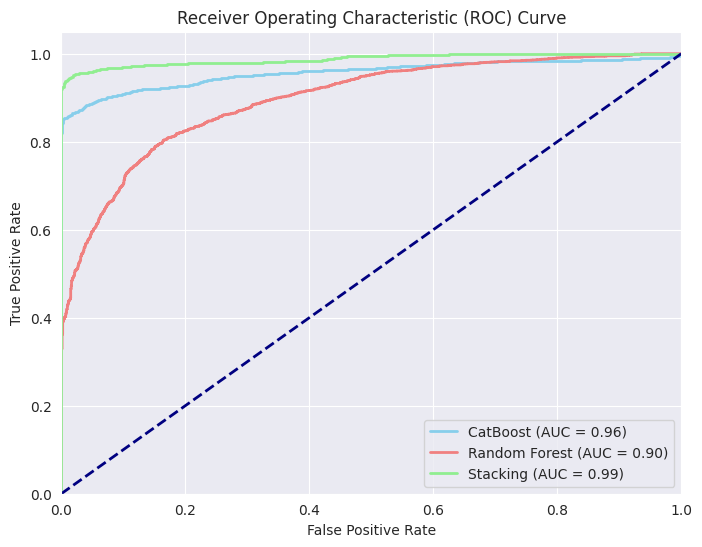

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='skyblue', lw=2, label=f'CatBoost (AUC = {roc_auc_catboost:.2f})')
plt.plot(fpr_rf, tpr_rf, color='lightcoral', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_stacking, tpr_stacking, color='lightgreen', lw=2, label=f'Stacking (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<div></div>

$\text{Plot the Precision-Recall curves}$

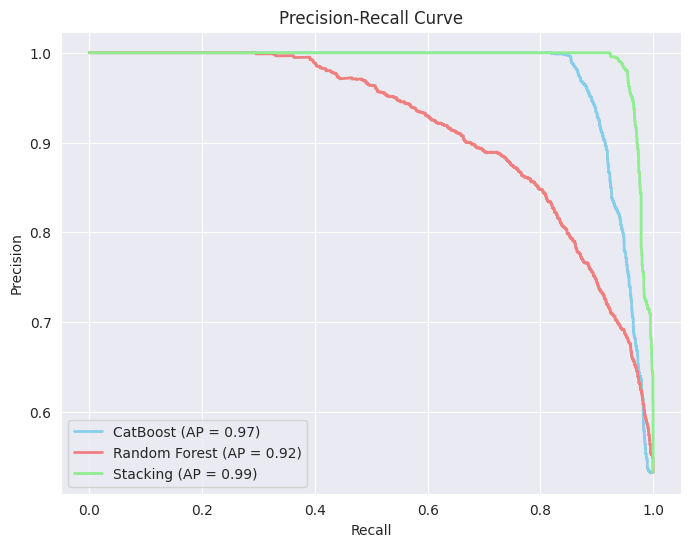

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall_catboost, precision_catboost, color='skyblue', lw=2, label=f'CatBoost (AP = {ap_catboost:.2f})')
plt.plot(recall_rf, precision_rf, color='lightcoral', lw=2, label=f'Random Forest (AP = {ap_rf:.2f})')
plt.plot(recall_stacking, precision_stacking, color='lightgreen', lw=2, label=f'Stacking (AP = {ap_stacking:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### $\text{Recommendations}$

1. The highest churn occurs in the fifth month of a driver's tenure with the company. Therefore, we can pay extra attention to drivers during their second quarter of tenure.

2. The income of the majority of churned drivers is half that of drivers who stayed. To address this, we can introduce incentives for drivers, specifically during their second quarter, and for overtime in general.

3. Low quarterly ratings, driving skills, and passenger experience are important factors that impact a driver's contribution to the total business value.
 - We can offer drivers etiquette classes periodically and make passing an exam for these classes compulsory for continued employment.